Using CPU
Basins: [0, 1, 2]
ibuc=0 Train[0,131495]  Val[131496,157775]  Test[157776,175320]
ibuc=1 Train[0,131495]  Val[131496,157775]  Test[157776,175320]
ibuc=2 Train[0,131495]  Val[131496,157775]  Test[157776,175320]

TRAINING STATELESS (STANDARD) LSTM
[Stateless] Epoch 00 | lr=0.001000 | Loss: 0.8960 | RMSE: 0.9466
[Stateless] Epoch 01 | lr=0.001000 | Loss: 0.8395 | RMSE: 0.9162
[Stateless] Epoch 02 | lr=0.001000 | Loss: 0.7708 | RMSE: 0.8780
[Stateless] Epoch 03 | lr=0.001000 | Loss: 0.7187 | RMSE: 0.8478
[Stateless] Epoch 04 | lr=0.001000 | Loss: 0.6874 | RMSE: 0.8291
[TIME] Stateless TRAIN total: 1791.964 s

TRAINING PERSISTENT (STATEFUL) LSTM
[Persistent] Epoch 00 | lr=0.001000 | Loss: 0.9179 | RMSE: 0.9581
[Persistent] Epoch 01 | lr=0.001000 | Loss: 0.8869 | RMSE: 0.9417
[Persistent] Epoch 02 | lr=0.001000 | Loss: 0.7926 | RMSE: 0.8903
[Persistent] Epoch 03 | lr=0.001000 | Loss: 0.7042 | RMSE: 0.8392
[Persistent] Epoch 04 | lr=0.001000 | Loss: 0.6331 | RMSE: 0.7957
[TIME] Pers

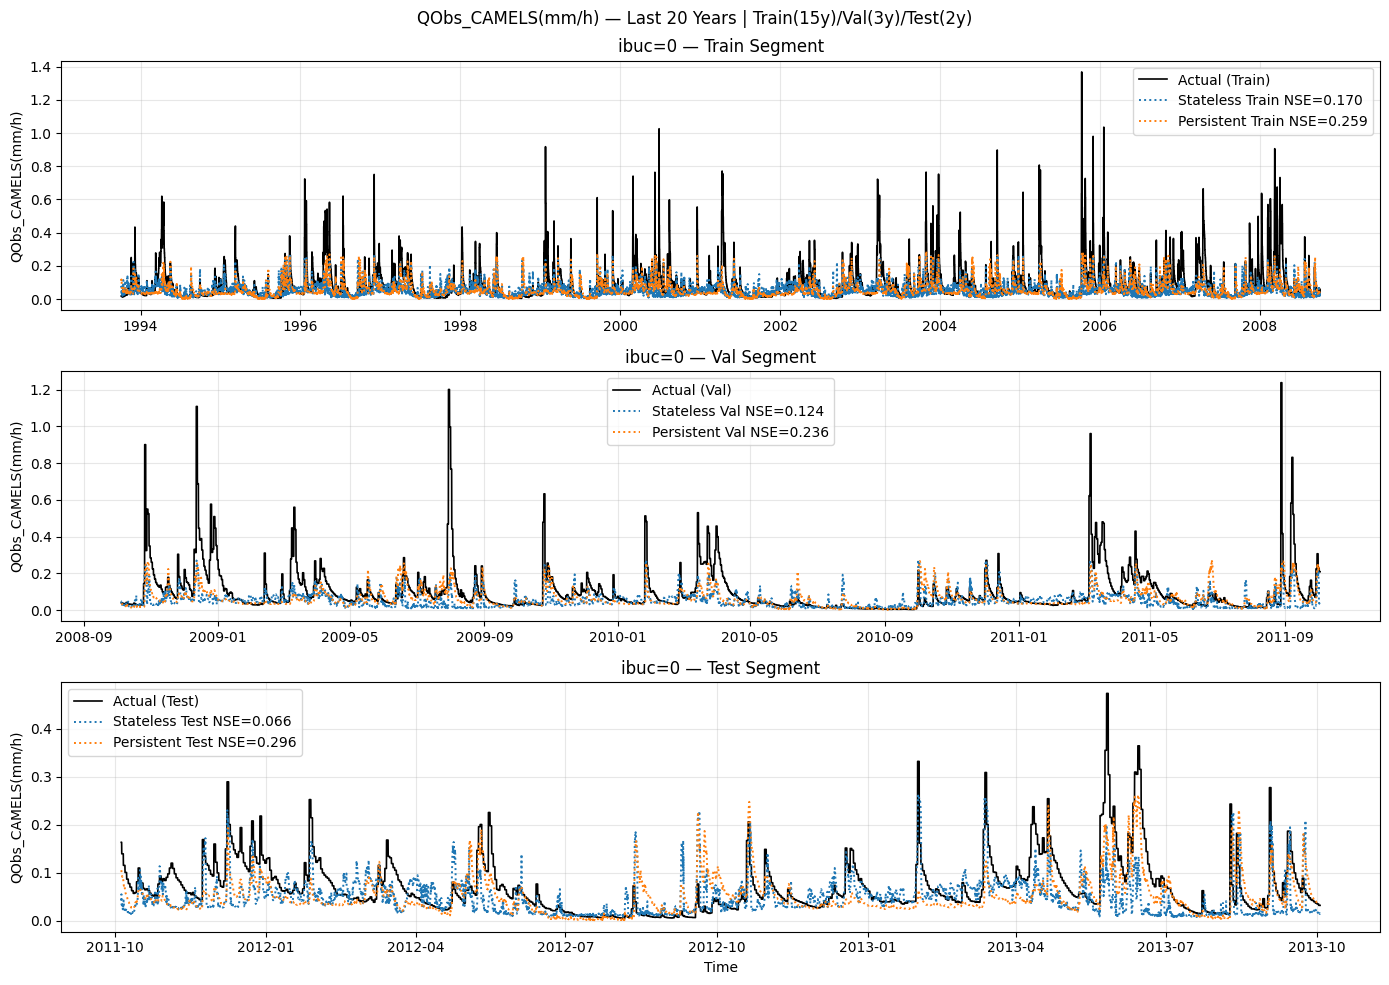

Plotting ibuc=1 …


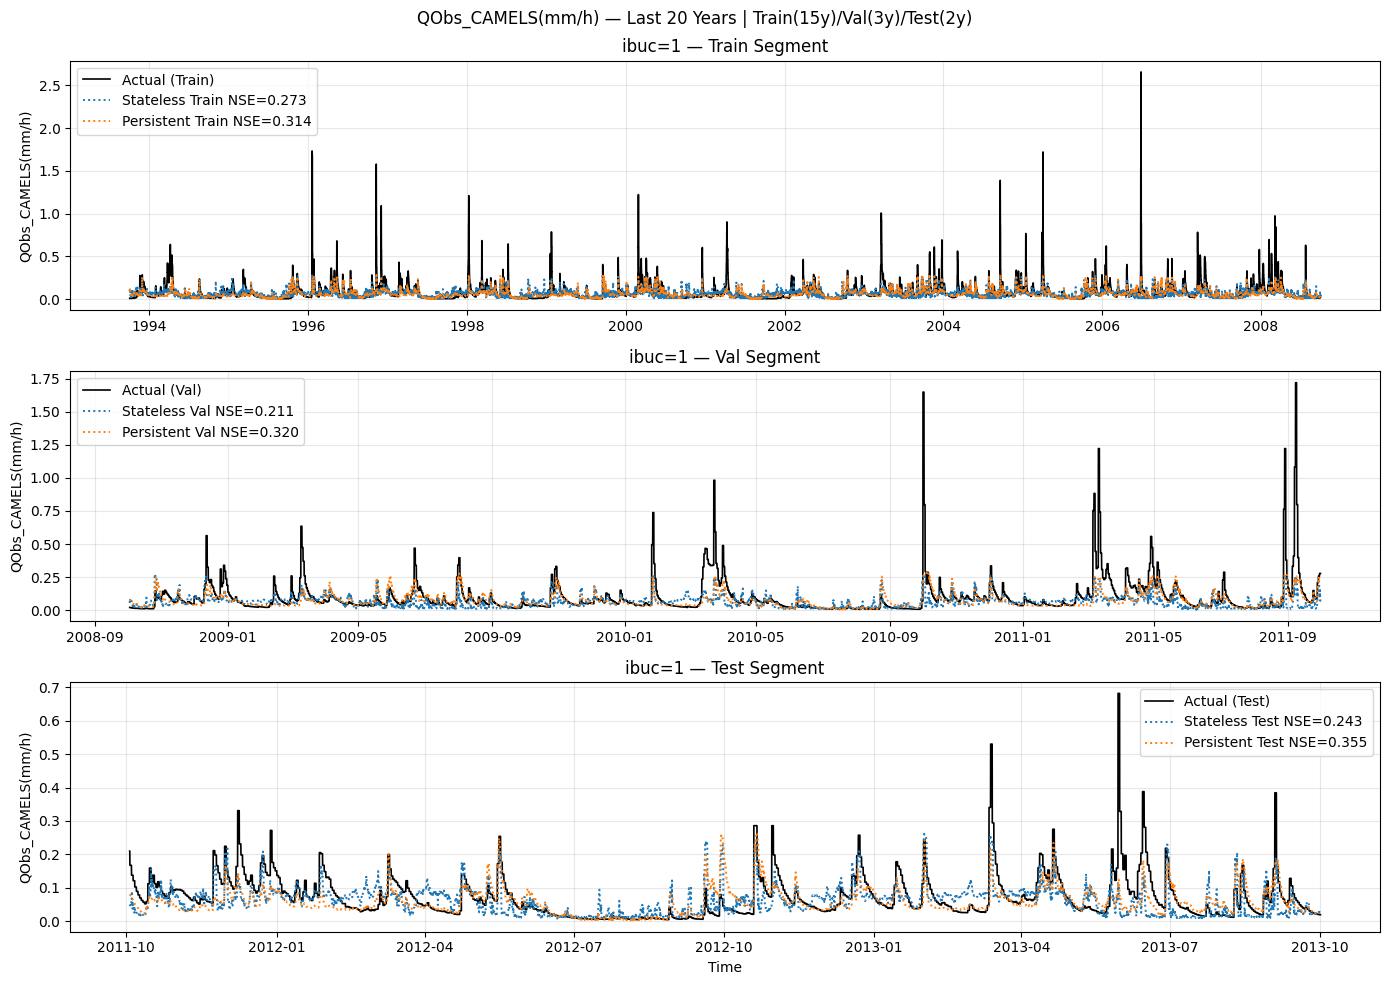

Plotting ibuc=2 …


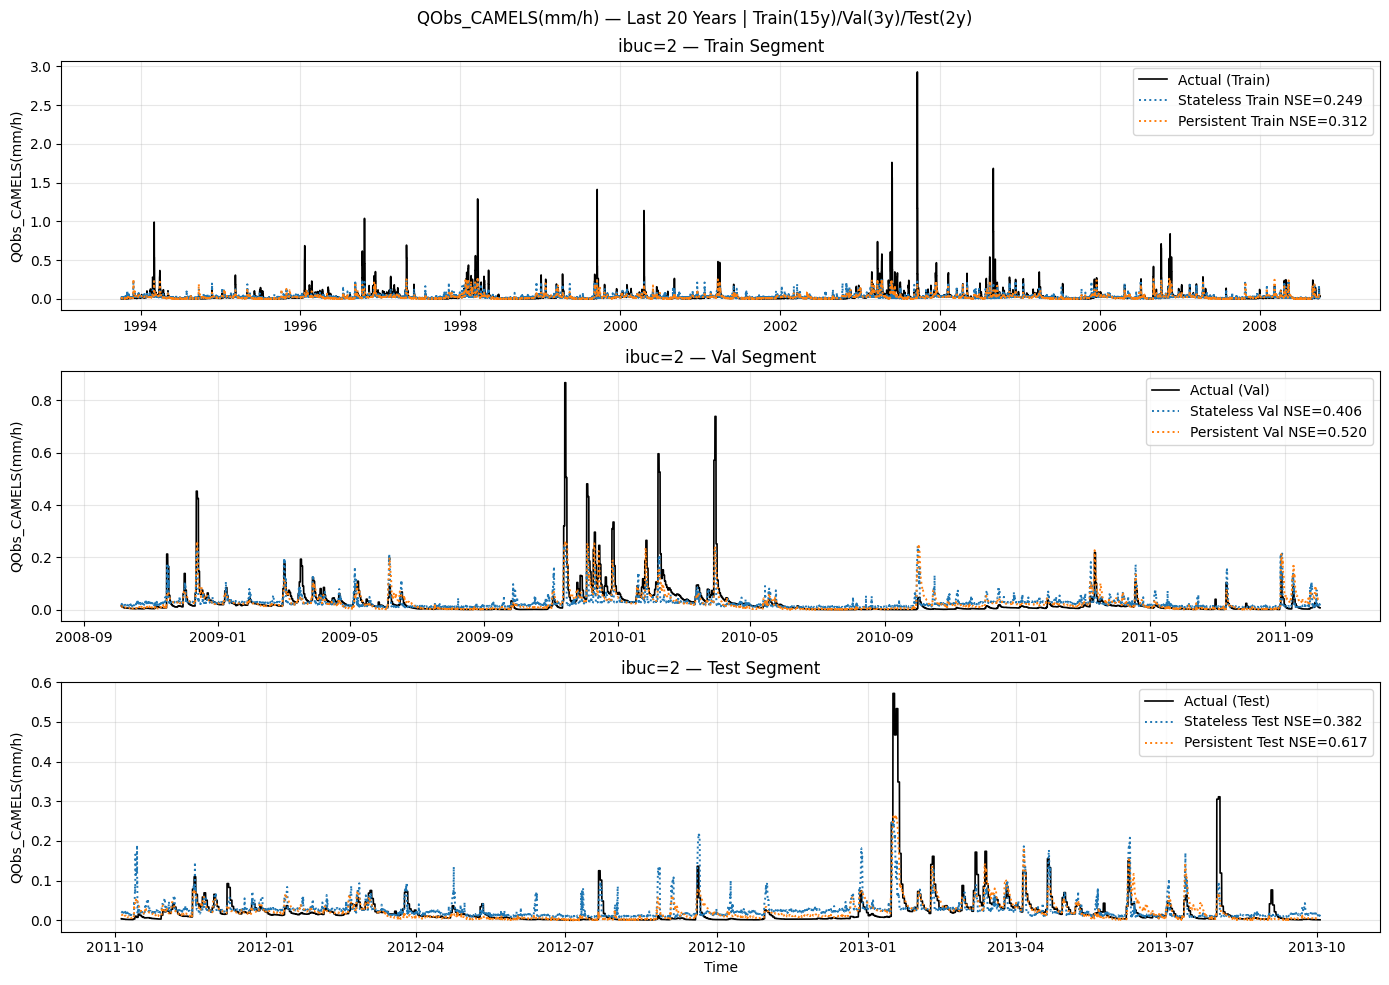

In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-

import time
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.preprocessing import StandardScaler
from torch.utils.data import TensorDataset, DataLoader, Sampler

# ----------------------------
# Device
# ----------------------------
if torch.cuda.is_available():
    device = torch.device("cuda:0")
    print("Using CUDA:", torch.cuda.get_device_name(0))
elif hasattr(torch.backends, "mps") and torch.backends.mps.is_available():
    device = torch.device("mps")
    print("Using Apple Silicon (Metal)")
else:
    device = torch.device("cpu")
    print("Using CPU")

# ----------------------------
# Columns
# ----------------------------
camels_input_cols = [
    "convective_fraction",
    "longwave_radiation",
    "potential_energy",
    "potential_evaporation",
    "pressure",
    "shortwave_radiation",
    "specific_humidity",
    "temperature",
    "total_precipitation",
    "wind_u",
    "wind_v",
]
target_col = "QObs_CAMELS(mm/h)"

def load_camels_hourly(input_csv, output_csv):
    df_x = pd.read_csv(input_csv)
    df_y = pd.read_csv(output_csv)
    df_x["date"] = pd.to_datetime(df_x["date"])
    df_y["date"] = pd.to_datetime(df_y["date"])
    df_x = df_x[["date"] + camels_input_cols]
    df_y = df_y["date"].to_frame().join(df_y[target_col])
    df = (
        pd.merge(df_x, df_y, on="date", how="inner")
        .dropna(subset=camels_input_cols + [target_col])
        .sort_values("date")
        .reset_index(drop=True)
    )
    df.index = np.arange(len(df))
    return df

BASINS = [
    dict(
        ibuc=0,
        X="CAMELS_data_sample/hourly/nldas_hourly/01333000_hourly_nldas.csv",
        Y="CAMELS_data_sample/hourly/usgs-streamflow/01333000-usgs-hourly.csv",
    ),
    dict(
        ibuc=1,
        X="CAMELS_data_sample/hourly/nldas_hourly/01423000_hourly_nldas.csv",
        Y="CAMELS_data_sample/hourly/usgs-streamflow/01423000-usgs-hourly.csv",
    ),
    dict(
        ibuc=2,
        X="CAMELS_data_sample/hourly/nldas_hourly/02046000_hourly_nldas.csv",
        Y="CAMELS_data_sample/hourly/usgs-streamflow/02046000-usgs-hourly.csv",
    ),
]

bucket_dictionary = {b["ibuc"]: load_camels_hourly(b["X"], b["Y"]) for b in BASINS}

# ----------------------------
# Params
# ----------------------------
seq_length            = 48            # length of each sequence in time
input_vars            = camels_input_cols
output_vars           = [target_col]
n_input               = len(input_vars)
n_output              = len(output_vars)

hidden_state_size     = 64
num_layers            = 2
num_epochs            = 5
k_preds               = 1              # last-step prediction for standard LSTM

batch_size_stateless  = seq_length     # number of windows per batch (standard)
windows_per_batch     = seq_length     # number of windows per batch (persistent)

learning_rate         = np.array([1e-3] * num_epochs)
DROPOUT_P             = 0.3

# ============================================================
# USE ONLY LAST 20 YEARS, THEN 15y/4y/1y SPLIT
# ============================================================
YEARS_BACK = 20
TRAIN_YEARS, VAL_YEARS, TEST_YEARS = 15, 3, 2

def restrict_to_last_years(df, years_back=5):
    end_date = df["date"].max()
    start_date = end_date - pd.DateOffset(years=years_back)
    df2 = df[df["date"] >= start_date].copy().reset_index(drop=True)
    df2.index = np.arange(len(df2))
    if len(df2) < seq_length * 4:
        raise ValueError(f"Not enough rows after {years_back}y restriction: {len(df2)}")
    return df2

for ibuc in bucket_dictionary:
    bucket_dictionary[ibuc] = restrict_to_last_years(
        bucket_dictionary[ibuc], years_back=YEARS_BACK
    )

def compute_date_splits(df, train_years, val_years, test_years, seq_length):
    """
    Compute train/val/test index boundaries based on years.
    Ensures each split contains at least one full window of length seq_length.
    """
    end_date = df["date"].max()

    test_start_date  = end_date - pd.DateOffset(years=test_years)
    val_start_date   = test_start_date - pd.DateOffset(years=val_years)
    train_start_date = val_start_date - pd.DateOffset(years=train_years)
    train_start_date = max(train_start_date, df["date"].min())

    i_train_start = int(df["date"].searchsorted(train_start_date, side="left"))
    i_val_start   = int(df["date"].searchsorted(val_start_date,   side="left"))
    i_test_start  = int(df["date"].searchsorted(test_start_date,  side="left"))
    i_end         = len(df) - 1

    assert (i_val_start - i_train_start) >= seq_length, "Train slice too short for seq_length"
    assert (i_test_start - i_val_start)  >= seq_length, "Val slice too short for seq_length"
    assert (i_end + 1 - i_test_start)    >= seq_length, "Test slice too short for seq_length"

    return {
        "train": (i_train_start, i_val_start - 1),
        "val":   (i_val_start,   i_test_start - 1),
        "test":  (i_test_start,  i_end),
    }

date_splits = {
    ibuc: compute_date_splits(
        bucket_dictionary[ibuc],
        train_years=TRAIN_YEARS,
        val_years=VAL_YEARS,
        test_years=TEST_YEARS,
        seq_length=seq_length
    )
    for ibuc in bucket_dictionary
}

buckets_for_training = list(bucket_dictionary.keys())
print("Basins:", buckets_for_training)
for ibuc in buckets_for_training:
    tr = date_splits[ibuc]["train"]; va = date_splits[ibuc]["val"]; te = date_splits[ibuc]["test"]
    print(f"ibuc={ibuc} Train[{tr[0]},{tr[1]}]  Val[{va[0]},{va[1]}]  Test[{te[0]},{te[1]}]")

# ----------------------------
# Scalers
# ----------------------------
def fit_scaler_multi():
    frames_in, frames_out = [], []
    for ibuc in buckets_for_training:
        s,e = date_splits[ibuc]["train"]
        df = bucket_dictionary[ibuc]
        frames_in.append(df.loc[s:e, input_vars])
        frames_out.append(df.loc[s:e, output_vars])
    df_in  = pd.concat(frames_in,  axis=0)
    df_out = pd.concat(frames_out, axis=0)
    scaler_in  = StandardScaler().fit(df_in)
    scaler_out = StandardScaler().fit(df_out)
    return scaler_in, scaler_out

scaler_in, scaler_out = fit_scaler_multi()

def _denorm_from_scaler(x_std):
    mu = float(scaler_out.mean_[0])
    sd = float(scaler_out.scale_[0])
    return max(x_std * sd + mu, 0.0)

# ============================================================
# Windowed arrays
# ============================================================
def make_window_arrays(df, start_idx, end_idx, seq_length):
    """Create OVERLAPPING windows for stateless LSTM (step=1)."""
    end_idx = min(end_idx, len(df) - 1)
    start_idx = min(start_idx, end_idx)
    Xin = scaler_in.transform(df.loc[start_idx:end_idx, input_vars])
    Yin = scaler_out.transform(df.loc[start_idx:end_idx, output_vars])

    n_total = Xin.shape[0]
    if n_total < seq_length:
        raise ValueError(f"Slice too short: n_total={n_total}, seq_length={seq_length}")

    n_samples = n_total - seq_length + 1
    X = np.zeros((n_samples, seq_length, n_input), dtype=np.float32)
    Y = np.zeros((n_samples, seq_length, n_output), dtype=np.float32)
    for i in range(n_samples):
        t0 = i + seq_length
        X[i] = Xin[i:t0]
        Y[i] = Yin[i:t0]
    return X, Y

def make_persistent_window_arrays(df, start_idx, end_idx, seq_length):
    """Create NON-OVERLAPPING windows for persistent LSTM (step=seq_length)."""
    end_idx = min(end_idx, len(df) - 1)
    start_idx = min(start_idx, end_idx)
    Xin = scaler_in.transform(df.loc[start_idx:end_idx, input_vars])
    Yin = scaler_out.transform(df.loc[start_idx:end_idx, output_vars])

    n_total = Xin.shape[0]
    if n_total < seq_length:
        raise ValueError(f"Slice too short: n_total={n_total}, seq_length={seq_length}")

    n_samples = n_total // seq_length
    X = np.zeros((n_samples, seq_length, n_input), dtype=np.float32)
    Y = np.zeros((n_samples, seq_length, n_output), dtype=np.float32)
    for i in range(n_samples):
        s = i * seq_length
        e = s + seq_length
        X[i] = Xin[s:e]
        Y[i] = Yin[s:e]
    return X, Y

class SequentialNonOverlappingSampler(Sampler):
    """
    Sampler for sequential processing of NON-OVERLAPPING windows within batches.
    Handles "last short batch" so segments with few windows still work.
    """
    def __init__(self, n_samples: int, windows_per_batch: int):
        self.n_samples = n_samples
        self.windows_per_batch = max(1, windows_per_batch)
        self.num_batches = max(1, math.ceil(n_samples / self.windows_per_batch))

    def __iter__(self):
        for i in range(self.num_batches):
            start = i * self.windows_per_batch
            end = min(start + self.windows_per_batch, self.n_samples)
            if start >= end:
                break
            yield list(range(start, end))

    def __len__(self):
        return self.num_batches

def make_stateless_loader(start, end, ibuc_list, batch_size):
    """Standard/stateless loader with OVERLAPPING windows."""
    loader = {}
    arraysX, arraysY = {}, {}
    for ibuc in ibuc_list:
        df = bucket_dictionary[ibuc]
        X, Y = make_window_arrays(df, start, end, seq_length)
        arraysX[ibuc], arraysY[ibuc] = X, Y
        ds = TensorDataset(torch.from_numpy(X), torch.from_numpy(Y))
        loader[ibuc] = DataLoader(ds, batch_size=batch_size, shuffle=False, drop_last=True)
    return loader, arraysX, arraysY

def make_persistent_loader(start, end, ibuc_list, windows_per_batch):
    """Persistent loader with NON-OVERLAPPING windows processed sequentially."""
    loader = {}
    arraysX, arraysY = {}, {}
    for ibuc in ibuc_list:
        df = bucket_dictionary[ibuc]
        X, Y = make_persistent_window_arrays(df, start, end, seq_length)
        arraysX[ibuc], arraysY[ibuc] = X, Y
        ds = TensorDataset(torch.from_numpy(X), torch.from_numpy(Y))
        sampler = SequentialNonOverlappingSampler(
            n_samples=X.shape[0],
            windows_per_batch=windows_per_batch
        )
        loader[ibuc] = DataLoader(ds, batch_sampler=sampler)
    return loader, arraysX, arraysY

def build_all_loaders():
    train_loader_std, val_loader_std, test_loader_std = {}, {}, {}
    train_loader_pers, val_loader_pers, test_loader_pers = {}, {}, {}
    np_train_seq_X, np_val_seq_X, np_test_seq_X = {}, {}, {}
    np_train_seq_y, np_val_seq_y, np_test_seq_y = {}, {}, {}

    for ibuc in bucket_dictionary:
        s_tr, e_tr = date_splits[ibuc]["train"]
        s_va, e_va = date_splits[ibuc]["val"]
        s_te, e_te = date_splits[ibuc]["test"]

        # Stateless
        ld, X, Y = make_stateless_loader(s_tr, e_tr, [ibuc], batch_size_stateless)
        train_loader_std[ibuc] = ld[ibuc]
        np_train_seq_X[ibuc] = X[ibuc]
        np_train_seq_y[ibuc] = Y[ibuc]

        ld, X, Y = make_stateless_loader(s_va, e_va, [ibuc], batch_size_stateless)
        val_loader_std[ibuc] = ld[ibuc]
        np_val_seq_X[ibuc] = X[ibuc]
        np_val_seq_y[ibuc] = Y[ibuc]

        ld, X, Y = make_stateless_loader(s_te, e_te, [ibuc], batch_size_stateless)
        test_loader_std[ibuc] = ld[ibuc]
        np_test_seq_X[ibuc] = X[ibuc]
        np_test_seq_y[ibuc] = Y[ibuc]

        # Persistent
        ld, _, _ = make_persistent_loader(s_tr, e_tr, [ibuc], windows_per_batch)
        train_loader_pers[ibuc] = ld[ibuc]

        ld, _, _ = make_persistent_loader(s_va, e_va, [ibuc], windows_per_batch)
        val_loader_pers[ibuc] = ld[ibuc]

        ld, _, _ = make_persistent_loader(s_te, e_te, [ibuc], windows_per_batch)
        test_loader_pers[ibuc] = ld[ibuc]

    return (train_loader_std, val_loader_std, test_loader_std,
            train_loader_pers, val_loader_pers, test_loader_pers,
            np_train_seq_X, np_val_seq_X, np_test_seq_X,
            np_train_seq_y, np_val_seq_y, np_test_seq_y)

# Build loaders
(train_loader_std, val_loader_std, test_loader_std,
 train_loader_pers, val_loader_pers, test_loader_pers,
 np_train_seq_X, np_val_seq_X, np_test_seq_X,
 np_train_seq_y, np_val_seq_y, np_test_seq_y) = build_all_loaders()

# ============================================================
# SHARED MODEL (same architecture for both methods)
# ============================================================
class LSTMShared(nn.Module):
    """Single LSTM architecture for both stateless and persistent modes."""
    def __init__(self, num_classes, input_size, hidden_size, num_layers, dropout_p=0.3):
        super().__init__()
        self.lstm = nn.LSTM(
            input_size=input_size,
            hidden_size=hidden_size,
            num_layers=num_layers,
            batch_first=True,
            dropout=dropout_p,
        )
        self.dropout = nn.Dropout(p=dropout_p)
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x, hidden_states=None, stateful=False):
        """
        If stateful=True, expects/returns hidden state (for persistent mode).
        If stateful=False, initializes fresh hidden state per batch (standard mode).
        """
        if (not stateful) or (hidden_states is None):
            B = x.size(0)
            h0 = torch.zeros(self.lstm.num_layers, B, self.lstm.hidden_size, device=x.device)
            c0 = torch.zeros(self.lstm.num_layers, B, self.lstm.hidden_size, device=x.device)
            hidden_states = (h0, c0)

        out, new_hidden = self.lstm(x, hidden_states)
        out = self.dropout(out)
        pred = self.fc(out)

        if stateful:
            return pred, new_hidden
        else:
            return pred

# ============================================================
# Training: STANDARD (stateless)
# ============================================================
def train_stateless(model, train_loader, buckets_for_training):
    """Standard/stateless: last-step loss on overlapping windows."""
    model.train()
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=float(learning_rate[0]), weight_decay=1e-5)

    epoch_losses = []
    t0_train = time.perf_counter()

    for epoch in range(num_epochs):
        for g in optimizer.param_groups:
            g['lr'] = float(learning_rate[epoch])

        epoch_loss = 0.0
        total_batches = 0

        for ibuc in buckets_for_training:
            for data, targets in train_loader[ibuc]:
                data, targets = data.to(device), targets.to(device)
                optimizer.zero_grad()
                out = model(data, stateful=False)           # stateless forward
                preds = out[:, -k_preds:, :]                # last step(s)
                true  = targets[:, -k_preds:, :]
                loss = criterion(preds, true)
                loss.backward()
                torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                optimizer.step()
                epoch_loss += loss.item()
                total_batches += 1

        avg_epoch_loss = epoch_loss / total_batches if total_batches > 0 else 0.0
        avg_epoch_rmse = float(np.sqrt(avg_epoch_loss))
        epoch_losses.append(avg_epoch_loss)
        print(f"[Stateless] Epoch {epoch:02d} | lr={optimizer.param_groups[0]['lr']:.6f} | "
              f"Loss: {avg_epoch_loss:.4f} | RMSE: {avg_epoch_rmse:.4f}")

    t1_train = time.perf_counter()
    print(f"[TIME] Stateless TRAIN total: {t1_train - t0_train:.3f} s")

    results = {ibuc: {"loss": epoch_losses,
                      "RMSE": [float(np.sqrt(l)) for l in epoch_losses]}
               for ibuc in buckets_for_training}
    return model, results, (t1_train - t0_train)

# ============================================================
# Training: PERSISTENT (stateful)
# ============================================================
def train_persistent(model, train_loader, buckets_for_training, windows_per_batch):
    """
    Persistent/stateful: Non-overlapping windows, sequential inside batch,
    carry state across windows/batches. Loss on ALL points in each window.
    """
    model.train()
    optimizer = optim.Adam(model.parameters(), lr=float(learning_rate[0]), weight_decay=1e-5)
    criterion = nn.MSELoss()

    epoch_losses = []
    t0_train = time.perf_counter()

    for epoch in range(num_epochs):
        for g in optimizer.param_groups:
            g['lr'] = float(learning_rate[epoch])

        epoch_loss = 0.0
        total_windows = 0

        for ibuc in buckets_for_training:
            saved_states = None  # reset between basins

            for (data, targets) in train_loader[ibuc]:
                data, targets = data.to(device), targets.to(device)
                current_states = saved_states

                # Process each window sequentially, carrying state
                B = data.size(0)  # may be < windows_per_batch in last batch
                for window_pos in range(B):
                    window_x = data[window_pos:window_pos+1]       # [1, L, F]
                    window_y = targets[window_pos:window_pos+1]    # [1, L, C]

                    optimizer.zero_grad()
                    out, new_hidden = model(window_x,
                                            hidden_states=current_states,
                                            stateful=True)
                    loss = criterion(out, window_y)                # ALL steps loss
                    loss.backward()
                    torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
                    optimizer.step()

                    epoch_loss += loss.item()
                    total_windows += 1

                    # Detach & keep values for next window
                    if new_hidden is not None:
                        current_states = (new_hidden[0].detach(), new_hidden[1].detach())

                # Save for next batch (state continues across batches)
                saved_states = current_states

        avg_epoch_loss = epoch_loss / total_windows if total_windows > 0 else 0.0
        avg_epoch_rmse = float(np.sqrt(avg_epoch_loss))
        epoch_losses.append(avg_epoch_loss)
        print(f"[Persistent] Epoch {epoch:02d} | lr={optimizer.param_groups[0]['lr']:.6f} | "
              f"Loss: {avg_epoch_loss:.4f} | RMSE: {avg_epoch_rmse:.4f}")

    t1_train = time.perf_counter()
    print(f"[TIME] Persistent TRAIN total: {t1_train - t0_train:.3f} s")

    results = {ibuc: {"loss": epoch_losses,
                      "RMSE": [float(np.sqrt(l)) for l in epoch_losses]}
               for ibuc in buckets_for_training}
    return model, results, (t1_train - t0_train)

# ============================================================
# Evaluation & plotting
# ============================================================
def compute_nse(pred, obs):
    pred = np.asarray(pred).ravel()
    obs  = np.asarray(obs).ravel()
    denom = np.sum((obs - np.mean(obs))**2)
    if denom == 0:
        return -999.0
    return 1.0 - np.sum((obs - pred)**2) / denom

def predict_block_stateless_last(model, np_seq_X_dict, ibuc):
    """Stateless predictions: last-step per overlapping window."""
    model.eval()
    X = torch.tensor(np_seq_X_dict[ibuc], dtype=torch.float32, device=device)
    with torch.no_grad():
        out = model(X, stateful=False)
        last = out[:, -1, :]
    preds = [_denorm_from_scaler(float(last[i, 0].cpu().numpy()))
             for i in range(last.shape[0])]
    return preds

def predict_block_persistent_allpoints(model, df, base_idx, end_idx):
    """
    Persistent predictions (NON-overlapping windows), bounded to [base_idx, end_idx].
    Returns (absolute_obs_indices, denorm_preds) for ALL time steps (dense coverage).
    """
    model.eval()
    X_np, _ = make_persistent_window_arrays(df, base_idx, end_idx, seq_length)
    Xfull = torch.tensor(X_np, dtype=torch.float32, device=device)  # [Nw, L, F]

    preds_idx, preds_val = [], []
    sampler = SequentialNonOverlappingSampler(
        n_samples=Xfull.size(0),
        windows_per_batch=windows_per_batch
    )
    saved_states = None

    with torch.no_grad():
        for batch_indices in sampler:
            data = Xfull[batch_indices]
            current_states = saved_states
            for window_pos, window_idx in enumerate(batch_indices):
                x = data[window_pos:window_pos+1]     # [1, L, F]
                out, new_hidden = model(x, hidden_states=current_states, stateful=True)  # [1, L, C]

                seq_pred = out[0, :, 0].cpu().numpy()  # [L]
                for step in range(seq_length):
                    obs_index = int(base_idx) + (window_idx * seq_length) + step
                    preds_idx.append(obs_index)
                    preds_val.append(_denorm_from_scaler(float(seq_pred[step])))

                if new_hidden is not None:
                    current_states = (new_hidden[0].detach(), new_hidden[1].detach())
            saved_states = current_states

    return preds_idx, preds_val

def obs_dense_for(df, start_idx, end_idx, n_preds, var):
    t0 = start_idx + (seq_length - 1)
    t1 = min(t0 + n_preds - 1, end_idx)
    obs = df.loc[t0:t1, var].values
    dates = df.loc[t0:t1, "date"].values
    return obs, dates

def nse_sparse(idx_list, preds_list, df, s, e, var):
    keep = [i for i in idx_list if (s + (seq_length - 1)) <= i <= e]
    if not keep:
        return np.nan
    m = {i: v for i, v in zip(idx_list, preds_list)}
    obs = [df.loc[i, var] for i in sorted(set(keep))]
    prd = [m[i] for i in sorted(set(keep))]
    return compute_nse(prd, obs)

def eval_all_basins_with_timing(model_stateless, model_persistent):
    per_basin = {}
    timings = {
        "stateless": {"train": 0.0, "val": 0.0, "test": 0.0},
        "persistent": {"train": 0.0, "val": 0.0, "test": 0.0},
    }

    print("\n" + "="*50)
    print("MODEL COMPARISON - NASH-SUTCLIFFE EFFICIENCY (NSE)")
    print("="*50)

    for ibuc in bucket_dictionary:
        df = bucket_dictionary[ibuc]
        s_tr,e_tr = date_splits[ibuc]["train"]
        s_va,e_va = date_splits[ibuc]["val"]
        s_te,e_te = date_splits[ibuc]["test"]

        # Stateless timing & NSE
        t0 = time.perf_counter()
        o_tr = predict_block_stateless_last(model_stateless, np_train_seq_X, ibuc)
        timings["stateless"]["train"] += (time.perf_counter() - t0)

        t0 = time.perf_counter()
        o_va = predict_block_stateless_last(model_stateless, np_val_seq_X,   ibuc)
        timings["stateless"]["val"] += (time.perf_counter() - t0)

        t0 = time.perf_counter()
        o_te = predict_block_stateless_last(model_stateless, np_test_seq_X,  ibuc)
        timings["stateless"]["test"] += (time.perf_counter() - t0)

        obs_tr,_ = obs_dense_for(df, s_tr, e_tr, len(o_tr), output_vars[0])
        obs_va,_ = obs_dense_for(df, s_va, e_va, len(o_va), output_vars[0])
        obs_te,_ = obs_dense_for(df, s_te, e_te, len(o_te), output_vars[0])
        nse_o_tr = compute_nse(o_tr[:len(obs_tr)], obs_tr)
        nse_o_va = compute_nse(o_va[:len(obs_va)], obs_va)
        nse_o_te = compute_nse(o_te[:len(obs_te)], obs_te)

        # Persistent timing & NSE (ALL points)
        t0 = time.perf_counter()
        idx_tr, p_tr = predict_block_persistent_allpoints(model_persistent, df, base_idx=s_tr, end_idx=e_tr)
        timings["persistent"]["train"] += (time.perf_counter() - t0)

        t0 = time.perf_counter()
        idx_va, p_va = predict_block_persistent_allpoints(model_persistent, df, base_idx=s_va, end_idx=e_va)
        timings["persistent"]["val"] += (time.perf_counter() - t0)

        t0 = time.perf_counter()
        idx_te, p_te = predict_block_persistent_allpoints(model_persistent, df, base_idx=s_te, end_idx=e_te)
        timings["persistent"]["test"] += (time.perf_counter() - t0)

        nse_p_tr = nse_sparse(idx_tr, p_tr, df, s_tr, e_tr, output_vars[0])
        nse_p_va = nse_sparse(idx_va, p_va, df, s_va, e_va, output_vars[0])
        nse_p_te = nse_sparse(idx_te, p_te, df, s_te, e_te, output_vars[0])

        per_basin[ibuc] = dict(orig=(nse_o_tr, nse_o_va, nse_o_te),
                               pers=(nse_p_tr, nse_p_va, nse_p_te))

        print(f"\nBasin {ibuc}:")
        print(f"  Stateless  - Train: {nse_o_tr:.4f}, Val: {nse_o_va:.4f}, Test: {nse_o_te:.4f}")
        print(f"  Persistent - Train: {nse_p_tr:.4f}, Val: {nse_p_va:.4f}, Test: {nse_p_te:.4f}")

    arr_o = np.array([per_basin[i]["orig"] for i in per_basin], dtype=float)
    arr_p = np.array([per_basin[i]["pers"] for i in per_basin], dtype=float)
    avg_orig = np.nanmean(arr_o, axis=0)
    avg_pers = np.nanmean(arr_p, axis=0)

    print(f"\n{'='*50}")
    print("MACRO-AVERAGE RESULTS:")
    print(f"{'='*50}")
    print(f"Stateless  - Train: {avg_orig[0]:.4f}, Val: {avg_orig[1]:.4f}, Test: {avg_orig[2]:.4f}")
    print(f"Persistent - Train: {avg_pers[0]:.4f}, Val: {avg_pers[1]:.4f}, Test: {avg_pers[2]:.4f}")

    return per_basin, avg_orig, avg_pers, timings

def plot_train_val_test_subplots_for(ibuc, model_stateless, model_persistent, var=target_col):
    """Plot for a single basin id with comparison between Stateless vs Persistent."""
    df = bucket_dictionary[ibuc]
    s_tr,e_tr = date_splits[ibuc]["train"]
    s_va,e_va = date_splits[ibuc]["val"]
    s_te,e_te = date_splits[ibuc]["test"]

    # Stateless (dense last-step per overlapping window)
    orig_train = predict_block_stateless_last(model_stateless, np_train_seq_X, ibuc)
    orig_val   = predict_block_stateless_last(model_stateless, np_val_seq_X,   ibuc)
    orig_test  = predict_block_stateless_last(model_stateless, np_test_seq_X,  ibuc)

    obs_tr, dates_tr = obs_dense_for(df, s_tr, e_tr, len(orig_train), var)
    obs_va, dates_va = obs_dense_for(df, s_va, e_va, len(orig_val),   var)
    obs_te, dates_te = obs_dense_for(df, s_te, e_te, len(orig_test),  var)

    NSE = lambda p,o: compute_nse(p[:len(o)], o)
    nse_o_tr, nse_o_va, nse_o_te = NSE(orig_train, obs_tr), NSE(orig_val, obs_va), NSE(orig_test, obs_te)

    # Persistent (ALL points, dense)
    idx_p_tr, pers_train = predict_block_persistent_allpoints(model_persistent, df, base_idx=s_tr, end_idx=e_tr)
    idx_p_va, pers_val   = predict_block_persistent_allpoints(model_persistent, df, base_idx=s_va, end_idx=e_va)
    idx_p_te, pers_test  = predict_block_persistent_allpoints(model_persistent, df, base_idx=s_te, end_idx=e_te)

    def build_dense_series_local(idx_list, preds_list, s, e):
        keep = [i for i in idx_list if (s + (seq_length - 1)) <= i <= e]
        if not keep:
            return np.array([]), np.array([]), np.array([])
        m = {i: v for i, v in zip(idx_list, preds_list)}
        idx_sorted = sorted(set(keep))
        obs = np.array([df.loc[i, var] for i in idx_sorted])
        prd = np.array([m[i] for i in idx_sorted])
        dates = pd.to_datetime(df.loc[idx_sorted, "date"].values)
        return dates, obs, prd

    dates_p_tr, obs_p_tr, prd_p_tr = build_dense_series_local(idx_p_tr, pers_train, s_tr, e_tr)
    dates_p_va, obs_p_va, prd_p_va = build_dense_series_local(idx_p_va, pers_val,   s_va, e_va)
    dates_p_te, obs_p_te, prd_p_te = build_dense_series_local(idx_p_te, pers_test,  s_te, e_te)

    nse_p_tr = compute_nse(prd_p_tr, obs_p_tr) if len(obs_p_tr) > 0 else np.nan
    nse_p_va = compute_nse(prd_p_va, obs_p_va) if len(obs_p_va) > 0 else np.nan
    nse_p_te = compute_nse(prd_p_te, obs_p_te) if len(obs_p_te) > 0 else np.nan

    fig, axes = plt.subplots(3, 1, figsize=(14, 10), sharex=False)
    panels = [
        ("Train", dates_tr, obs_tr, orig_train, (dates_p_tr, prd_p_tr), nse_o_tr, nse_p_tr),
        ("Val",   dates_va, obs_va, orig_val,   (dates_p_va, prd_p_va), nse_o_va, nse_p_va),
        ("Test",  dates_te, obs_te, orig_test,  (dates_p_te, prd_p_te), nse_o_te, nse_p_te),
    ]
    for ax, (name, dates, obs, orig_pred, (p_dates, p_pred), nse_o, nse_p) in zip(axes, panels):
        if len(obs) == 0:
            ax.set_title(f'ibuc={ibuc} — {name} Segment (no data)')
            ax.grid(True, alpha=0.3)
            continue
        ax.plot(dates, obs, '-', linewidth=1.2, color='k', label=f'Actual ({name})')
        ax.plot(dates, orig_pred[:len(dates)], ':', linewidth=1.4,
                label=f'Stateless {name} NSE={nse_o:.3f}')
        if len(p_dates) > 0:
            ax.plot(p_dates, p_pred, ':', linewidth=1.4,
                    label=f'Persistent {name} NSE={nse_p:.3f}')
        ax.set_ylabel(var)
        ax.set_title(f'ibuc={ibuc} — {name} Segment')
        ax.grid(True, alpha=0.3)
        ax.legend()
    axes[-1].set_xlabel('Time')
    fig.suptitle(f'{var} — Last 20 Years | Train(15y)/Val(3y)/Test(2y)', y=0.98)
    plt.tight_layout()
    plt.show()

# ----------------------------
# Main
# ----------------------------
if __name__ == "__main__":
    torch.manual_seed(1)

    # same architecture for both methods
    model_stateless  = LSTMShared(
        num_classes=n_output,
        input_size=n_input,
        hidden_size=hidden_state_size,
        num_layers=num_layers,
        dropout_p=DROPOUT_P
    ).to(device)

    model_persistent = LSTMShared(
        num_classes=n_output,
        input_size=n_input,
        hidden_size=hidden_state_size,
        num_layers=num_layers,
        dropout_p=DROPOUT_P
    ).to(device)

    print("\n" + "="*60)
    print("TRAINING STATELESS (STANDARD) LSTM")
    print("="*60)
    model_stateless, _, t_train_stateless = train_stateless(
        model_stateless, train_loader_std, buckets_for_training
    )

    print("\n" + "="*60)
    print("TRAINING PERSISTENT (STATEFUL) LSTM")
    print("="*60)
    model_persistent, _, t_train_persistent = train_persistent(
        model_persistent, train_loader_pers, buckets_for_training, windows_per_batch
    )

    # -------- EVALUATION: per-basin + macro-average + TIMINGS --------
    per_basin, avg_orig, avg_pers, timings = eval_all_basins_with_timing(
        model_stateless, model_persistent
    )

    print("\n" + "="*60)
    print("TIMINGS SUMMARY (seconds)")
    print("="*60)
    print(f"TRAIN — Stateless:  {t_train_stateless:.3f} s")
    print(f"TRAIN — Persistent: {t_train_persistent:.3f} s")
    print(f"PRED  — Stateless:  train={timings['stateless']['train']:.3f}, "
          f"val={timings['stateless']['val']:.3f}, test={timings['stateless']['test']:.3f}")
    print(f"PRED  — Persistent: train={timings['persistent']['train']:.3f}, "
          f"val={timings['persistent']['val']:.3f}, test={timings['persistent']['test']:.3f}")

    # -------- PLOT (all basins) --------
    print("\nPlotting all basins …")
    for ibuc in bucket_dictionary.keys():
        print(f"Plotting ibuc={ibuc} …")
        plot_train_val_test_subplots_for(
            ibuc=ibuc,
            model_stateless=model_stateless,
            model_persistent=model_persistent,
            var=output_vars[0]
        )
